In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import spline
%matplotlib inline

#Data source: https://www.kaggle.com/dansbecker/nba-shot-logs
df = pd.read_csv('shot_logs.csv')
df.head()

#Get number of records
#print(len(df))
#128069

#df_na = df.ix[lambda df: df['SHOT_CLOCK'].isnull()]
#print(len(df_na))
#5567

#Missing Shot Clock Pct = 5567 / 128069 = 4.3%

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [2]:
#Round off the decimal variables we want to use so that data is less volatile when plotted
df['SHOT_CLOCK_ROUND'] = df['SHOT_CLOCK'].round(0)
df['SHOT_DIST_ROUND'] = df['SHOT_DIST'].round(0)
df['CLOSE_DEF_ROUND'] = df['CLOSE_DEF_DIST'].round(0)
#df.head()

<Figure size 360x1080 with 0 Axes>

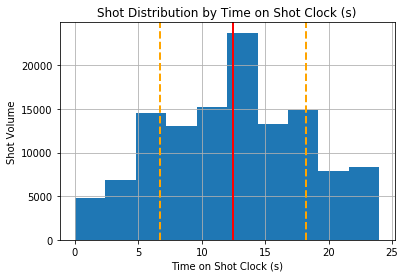

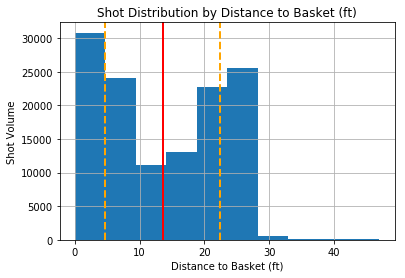

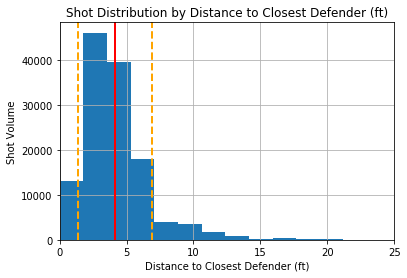

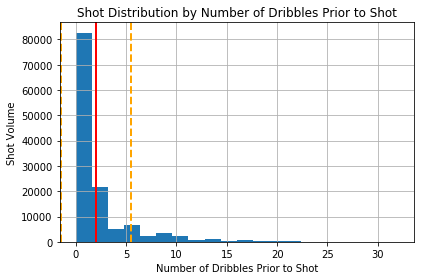

In [3]:
#Explore summary stats/distributions of important variables
plt.figure(figsize=(5,15))


shot_clock_avg = np.mean(df['SHOT_CLOCK_ROUND'])
shot_clock_dev = np.std(df['SHOT_CLOCK_ROUND'])
df.hist('SHOT_CLOCK_ROUND')
plt.axvline(shot_clock_avg, color = 'red', linestyle = 'solid', linewidth = 2)
plt.axvline(shot_clock_avg + shot_clock_dev, color = 'orange', linestyle = 'dashed', linewidth = 2)
plt.axvline(shot_clock_avg - shot_clock_dev, color = 'orange', linestyle = 'dashed', linewidth = 2)
plt.xlabel('Time on Shot Clock (s)')
plt.ylabel('Shot Volume')
plt.title('Shot Distribution by Time on Shot Clock (s)')


df.hist('SHOT_DIST_ROUND')
shot_dist_avg = np.mean(df['SHOT_DIST_ROUND'])
shot_dist_dev = np.std(df['SHOT_DIST_ROUND'])
plt.axvline(shot_dist_avg, color = 'red', linestyle = 'solid', linewidth = 2)
plt.axvline(shot_dist_avg + shot_dist_dev, color = 'orange', linestyle = 'dashed', linewidth = 2)
plt.axvline(shot_dist_avg - shot_dist_dev, color = 'orange', linestyle = 'dashed', linewidth = 2)
plt.xlabel('Distance to Basket (ft)')
plt.ylabel('Shot Volume')
plt.title('Shot Distribution by Distance to Basket (ft)')


df.hist('CLOSE_DEF_ROUND', bins = 30)
def_dist_avg = np.mean(df['CLOSE_DEF_ROUND'])
def_dist_dev = np.std(df['CLOSE_DEF_ROUND'])
plt.axvline(def_dist_avg, color = 'red', linestyle = 'solid', linewidth = 2)
plt.axvline(def_dist_avg + def_dist_dev, color = 'orange', linestyle = 'dashed', linewidth = 2)
plt.axvline(def_dist_avg - def_dist_dev, color = 'orange', linestyle = 'dashed', linewidth = 2)
plt.xlabel('Distance to Closest Defender (ft)')
plt.ylabel('Shot Volume')
plt.title('Shot Distribution by Distance to Closest Defender (ft)')
plt.xlim(0,25)


df.hist('DRIBBLES', bins = 20)
drib_avg = np.mean(df['DRIBBLES'])
drib_dev = np.std(df['DRIBBLES'])
plt.axvline(drib_avg, color = 'red', linestyle = 'solid', linewidth = 2)
plt.axvline(drib_avg + drib_dev, color = 'orange', linestyle = 'dashed', linewidth = 2)
plt.axvline(drib_avg - drib_dev, color = 'orange', linestyle = 'dashed', linewidth = 2)
plt.xlabel('Number of Dribbles Prior to Shot')
plt.ylabel('Shot Volume')
plt.title('Shot Distribution by Number of Dribbles Prior to Shot')

plt.tight_layout()
plt.show()





In [4]:
#Group the data by the rounded shot clock count
df3 = df.groupby('SHOT_CLOCK_ROUND', as_index = False).mean()
#df3.head(30)

In [6]:
#Below, I created groups based on shot distance and defender distance by looping through the rows of the df.

#There is a faster way, though less readable perhaps, right here for instance:

df['shot_group'] = df['SHOT_DIST_ROUND'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else (2 if x <= 12 else (3 if x <= 16 else (4 if x <= 20 else (5 if x <= 24 else 6))))))

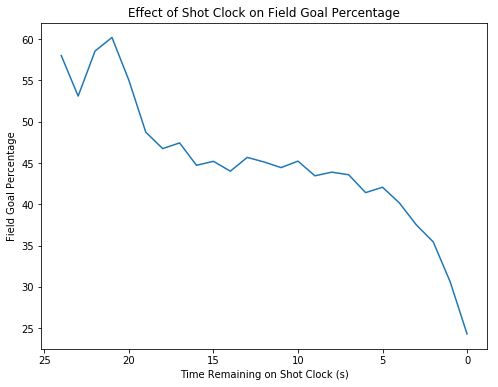

In [5]:
#Plot FG % by Shot Clock Count
plt.figure(figsize=(8,6))  
plt.plot(df3['FGM'] * 100)
plt.gca().invert_xaxis()
plt.xlabel('Time Remaining on Shot Clock (s)')
plt.ylabel('Field Goal Percentage')
plt.title('Effect of Shot Clock on Field Goal Percentage')
plt.show()

#Need to normalize for distance when we plot the FG% by shot clock time (theory is that lower shot clock counts 
#result in longer FG attempts). First step is to create reasonable buckets for distributions.

distance_bucket = []
def_distance_bucket = []
def_distance_bucket2 = []

for shot in range(len(df)):
    if df['SHOT_DIST_ROUND'][shot] <= 4:
        distance_bucket.append(0)
    elif df['SHOT_DIST_ROUND'][shot] <= 8:
        distance_bucket.append(1)
    elif df['SHOT_DIST_ROUND'][shot] <= 12:
        distance_bucket.append(2)
    elif df['SHOT_DIST_ROUND'][shot] <= 16:
        distance_bucket.append(3)
    elif df['SHOT_DIST_ROUND'][shot] <= 20:
        distance_bucket.append(4)
    elif df['SHOT_DIST_ROUND'][shot] <= 24:
        distance_bucket.append(5)
    else:
        distance_bucket.append(6)

        
for shot in range(len(df)):
    if df['CLOSE_DEF_ROUND'][shot] <= 2:
        def_distance_bucket.append(0)
    elif df['CLOSE_DEF_ROUND'][shot] <= 4:
        def_distance_bucket.append(1)
    elif df['CLOSE_DEF_ROUND'][shot] <= 6:
        def_distance_bucket.append(2)
    elif df['CLOSE_DEF_ROUND'][shot] <= 8:
        def_distance_bucket.append(3)
    elif df['CLOSE_DEF_ROUND'][shot] <= 10:
        def_distance_bucket.append(4)
    else:
        def_distance_bucket.append(5)        

        
for shot in range(len(df)):
    if df['CLOSE_DEF_ROUND'][shot] <= 1:
        def_distance_bucket2.append(0)
    elif df['CLOSE_DEF_ROUND'][shot] <= 2:
        def_distance_bucket2.append(1)
    elif df['CLOSE_DEF_ROUND'][shot] <= 3:
        def_distance_bucket2.append(2)
    elif df['CLOSE_DEF_ROUND'][shot] <= 4:
        def_distance_bucket2.append(3)
    elif df['CLOSE_DEF_ROUND'][shot] <= 5:
        def_distance_bucket2.append(4)
    elif df['CLOSE_DEF_ROUND'][shot] <= 6:
        def_distance_bucket2.append(5)
    elif df['CLOSE_DEF_ROUND'][shot] <= 7:
        def_distance_bucket2.append(6)
    elif df['CLOSE_DEF_ROUND'][shot] <= 8:
        def_distance_bucket2.append(7)
    elif df['CLOSE_DEF_ROUND'][shot] <= 9:
        def_distance_bucket2.append(8)
    elif df['CLOSE_DEF_ROUND'][shot] <= 10:
        def_distance_bucket2.append(9)
    else:
        def_distance_bucket2.append(10)          
        
#Add the grouped shot distance bucket column to the primary dataframe
df['SHOT_DIST_BUCKET'] = distance_bucket
df['DEF_DIST_BUCKET'] = def_distance_bucket
df['DEF_DIST_BUCKET2'] = def_distance_bucket2

#Make sure it worked
#df.head()    

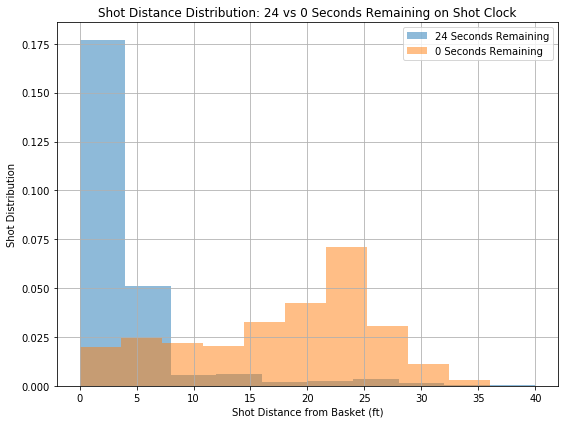

In [7]:
#Get distributions for shot distance at 24 seconds and at 0 seconds to test if we need to normalize for shot distance.
plt.figure(figsize=(8,6))  
df_24 = df.loc[lambda df: df['SHOT_CLOCK_ROUND'] == 24]['SHOT_DIST_ROUND']
df_0 = df.loc[lambda df: df['SHOT_CLOCK_ROUND'] == 0]['SHOT_DIST_ROUND']
df_24.hist(density = True, alpha = 0.5, label = '24 Seconds Remaining')
df_0.hist(density = True, alpha = 0.5, label = '0 Seconds Remaining')
plt.xlabel('Shot Distance from Basket (ft)')
plt.ylabel('Shot Distribution')
plt.title('Shot Distance Distribution: 24 vs 0 Seconds Remaining on Shot Clock')
plt.legend(loc='upper right')
plt.tight_layout()

In [13]:
#Get FG % by distance bucket
shot_bucket = df.groupby('SHOT_DIST_BUCKET').mean()
overall_fg_pct_dist = shot_bucket['FGM']
#print(overall_fg_pct_dist)

#Get FG Distribution by distance bucket
shot_dist = df.groupby('SHOT_DIST_BUCKET').count()
#Shot count by distance divided by total of all shots
overall_fg_dist = shot_dist['FGM'] / np.sum(shot_dist['FGM'])
#print(overall_fg_dist)

#Overall FG % for all shots, in case we are curious
#print(sum(overall_fg_pct_dist * overall_fg_dist))

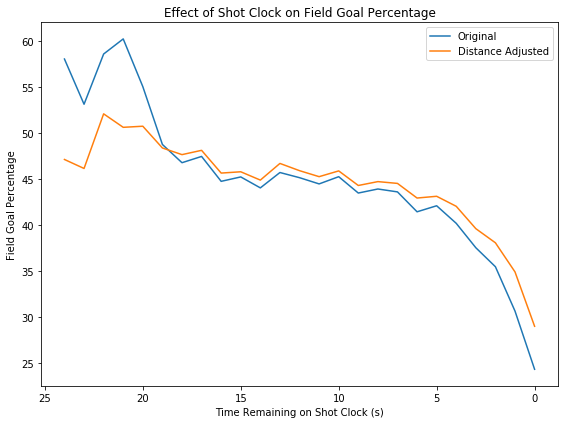

In [18]:
#Next we need the FG % for each distance bucket for each second in the game clock, which we will then multiply by the 
#overall FG distribution to adjust for different shot selection that occurs throughout the shot clock .


df_adjust = df.groupby(['SHOT_CLOCK_ROUND', 'SHOT_DIST_BUCKET'], as_index = False).mean()
df_adjust.head()

shot_clock_adj_by_distance = []

for x in range(len(np.unique(df['SHOT_CLOCK_ROUND']))):
    adj_term = df_adjust.loc[lambda df: df_adjust['SHOT_CLOCK_ROUND'] == x]['FGM'].reset_index(drop = True)
    #Get the field goal % for each distance bucket, for each second on the shot clock
    #Next, apply the same shot DISTANCE distribution to each second on the shot clock. This will effectively 
    #isolate the clock as the reason for any differences in field goal percentage.
    shot_clock_adj_by_distance.append(100 * sum(adj_term * overall_fg_dist))

plt.figure(figsize=(8,6))    
plt.plot(df3['FGM'] * 100, label = 'Original')
plt.plot(shot_clock_adj_by_distance, label = 'Distance Adjusted')
plt.gca().invert_xaxis()
plt.xlabel('Time Remaining on Shot Clock (s)')
plt.ylabel('Field Goal Percentage')
plt.title('Effect of Shot Clock on Field Goal Percentage')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

    

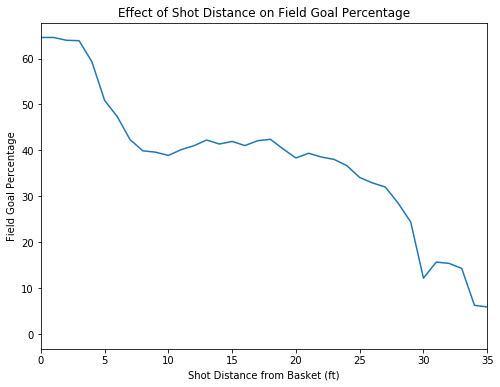

In [19]:
#Show overall FG % by shot distance
df4 = df.groupby('SHOT_DIST_ROUND').sum() / df.groupby('SHOT_DIST_ROUND').count()
#df4.head()

plt.figure(figsize=(8,6))
plt.xlim(0, 35)
plt.plot(df4['FGM'] * 100)
plt.xlabel('Shot Distance from Basket (ft)')
plt.ylabel('Field Goal Percentage')
plt.title('Effect of Shot Distance on Field Goal Percentage')
plt.show()

In [9]:
df2 = df.ix[lambda df: df['player_name'] == 'lebron james']
#df2.head()
#df6 = df2.groupby('CLOSE_DEF_ROUND').sum() / df2.groupby('CLOSE_DEF_ROUND').count()
#plt.xlim(0,8)
#plt.ylim(0.1, 0.8)
#plt.plot(df6['FGM'])
#df6.head()

#Get Lebron's FG % by distance bucket
lbj_shot_bucket = df2.groupby('SHOT_DIST_BUCKET').mean()
lbj_overall_fg_pct_dist = lbj_shot_bucket['FGM']
#print(lbj_overall_fg_pct_dist)

#Get FG Distribution by distance bucket
lbj_shot_dist = df2.groupby('SHOT_DIST_BUCKET').count()
lbj_overall_fg_dist = lbj_shot_dist['player_name'] / np.sum(lbj_shot_dist['FGM'])
#print(lbj_overall_fg_dist)

#Overall FG % for all shots, in case we are curious
#print(sum(lbj_overall_fg_pct_dist * lbj_overall_fg_dist))


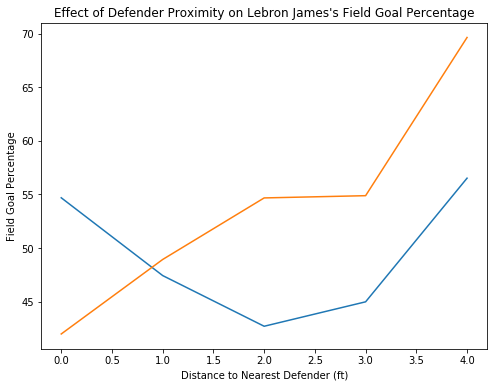

In [10]:
lbj_adjust = df2.groupby(['DEF_DIST_BUCKET', 'SHOT_DIST_BUCKET'], as_index = False).mean()
#lbj_adjust.head(20)

# create a list from 0 to 5
dist_bucket = range(6)

# create empty list
lbj_def_distance_and_shot_dist_adj_fg = []
# loop through each number in the range list and apply to 
for x in dist_bucket:
    # plug in X number to the dist bucket from grouped DF
    dist_fg_adj = lbj_adjust.ix[lambda df: lbj_adjust['DEF_DIST_BUCKET'] == x]['FGM'].reset_index(drop = True)
    # append sum of (dist adjusted data * lbj_overall) to lbj_def_distance_and_shot_dist_adj_fg list 
    lbj_def_distance_and_shot_dist_adj_fg.append(100 * sum(dist_fg_adj * lbj_overall_fg_dist)) 

#lebron's original FG % by defender distance:
plt.figure(figsize=(8,6))
lbj_orig = df2.groupby('DEF_DIST_BUCKET', as_index = False).mean()['FGM']
lbj_orig2 = lbj_orig.ix[0:4] * 100
#lbj_orig2.head()
plt.plot(lbj_orig2)
plt.plot(lbj_def_distance_and_shot_dist_adj_fg[0:5])

plt.xlabel('Distance to Nearest Defender (ft)')
plt.ylabel('Field Goal Percentage')
plt.title('Effect of Defender Proximity on Lebron James' + "'" 's Field Goal Percentage')
plt.show()

#Lebron's FG % by defender distance, adjusted for shot distance:
#print(lbj_def_distance_and_shot_dist_adj_fg)


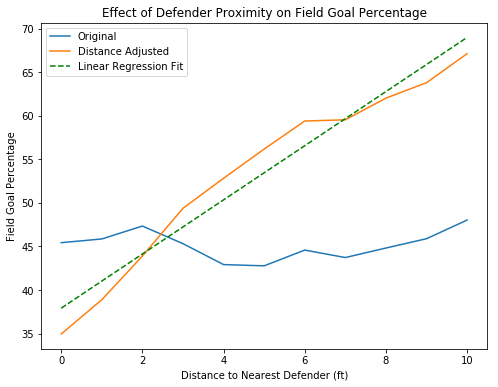

[  3.10763128  37.91815868]


In [88]:
league_adjust = df.groupby(['DEF_DIST_BUCKET2', 'SHOT_DIST_BUCKET'], as_index = False).mean()
#lbj_adjust.head(20)

# create a list from 0 to 5
dist_bucket = range(11)

# create empty list
league_def_distance_and_shot_dist_adj_fg = []
# loop through each number in the range list and apply to 
for x in dist_bucket:
    # plug in X number to the dist bucket from grouped DF
    dist_fg_adj = league_adjust.ix[lambda df: league_adjust['DEF_DIST_BUCKET2'] == x]['FGM'].reset_index(drop = True)
    # append sum of (dist adjusted data * lbj_overall) to lbj_def_distance_and_shot_dist_adj_fg list 
    league_def_distance_and_shot_dist_adj_fg.append(100 * sum(dist_fg_adj * overall_fg_dist)) 

#lebron's original FG % by defender distance:
#print(df2.groupby('DEF_DIST_BUCKET').mean()['FGM'])
league_orig = df.groupby('DEF_DIST_BUCKET2', as_index = False).mean()['FGM']
league_orig2 = league_orig.ix[0:10] * 100
#lbj_orig2.head()

plt.figure(figsize=(8,6))
plt.plot(league_orig2, label = 'Original')
plt.plot(league_def_distance_and_shot_dist_adj_fg, label = 'Distance Adjusted')

#Apply linear regression fit to the adjusted FG % Line (example: http://matthiaseisen.com/pp/patterns/p0170/)
fit = np.polyfit(range(len(league_def_distance_and_shot_dist_adj_fg)), league_def_distance_and_shot_dist_adj_fg, deg=1)
plt.plot(range(len(league_def_distance_and_shot_dist_adj_fg)), fit[0] * range(len(league_def_distance_and_shot_dist_adj_fg)) 
         + fit[1], color = 'g', linestyle = 'dashed', label = 'Linear Regression Fit')

plt.xlabel('Distance to Nearest Defender (ft)')
plt.ylabel('Field Goal Percentage')
plt.title('Effect of Defender Proximity on Field Goal Percentage')
plt.legend(loc = 'upper left')
plt.show()

#print(fit)
#Gives us a slope of 3.1 and an intercept of 37.9

In [29]:
#Who is the best defender in the NBA? Perform similar analysis by defender FG%, adjusting for shot distance. Ideally, we should
#also adjust for shot taker's FG% (for future study).

defender_grp = df.groupby('CLOSEST_DEFENDER', as_index = False).count()
defender_grp_sub = defender_grp.loc[lambda df: defender_grp['player_name'] >= 200]
defender_grp_sub.head()

#Get list of defenders with at least 100 shots taken against them
elig_def_list = defender_grp_sub['CLOSEST_DEFENDER'].tolist()

#Now re-create original dataframe with just the list of eligible defenders
df_elig_def = df.loc[lambda df: df['CLOSEST_DEFENDER'].isin(elig_def_list)]

#Obtain avg. FG% from this new dataframe
def_elig_def_fg = df_elig_def.groupby(['CLOSEST_DEFENDER', 'SHOT_DIST_BUCKET'], as_index = False).mean()

#Begin process of adjusting defender FG allowed % by shot distance
def_fg_pct_adj = []

#For each defender, get their FG allowed % by shot distance bucket, then apply the league average shot distribution 
#to each defender to adjust for different types of shots the player usually contests.

#Make sure to iterate through list of STRINGS here, not numbers (as we did above)

for x in elig_def_list:
    def_fg_adj = def_elig_def_fg.loc[lambda df: def_elig_def_fg['CLOSEST_DEFENDER'] == x]['FGM'].reset_index(drop = True)
    def_fg_pct_adj.append(sum(def_fg_adj * overall_fg_dist))

#Adjust decimal to percentage for FG %
x = elig_def_list
y = def_fg_pct_adj

new_df = pd.DataFrame()

new_df['Defender'] = elig_def_list
new_df['Adjusted_FG_Pct_Allowed'] = def_fg_pct_adj
new_df['League_Avg_FG_Pct_Allowed'] = sum(overall_fg_pct_dist * overall_fg_dist)
new_df['Net_FG_Pct_Differential'] = def_fg_pct_adj - sum(overall_fg_pct_dist * overall_fg_dist)
new_df['Net_FG_Pct_Differential2'] = new_df['Net_FG_Pct_Differential'] * 100


#Create dataframes for the best and worst defenders
worst_def = new_df.nlargest(10, columns = 'Net_FG_Pct_Differential2')
best_def = new_df.nsmallest(10, columns = 'Net_FG_Pct_Differential2')

#Union those two dataframes
frames = [worst_def, best_def]
result = pd.concat(frames)

#Sort the result properly for visualization
result_sorted = result.sort_values(by = 'Net_FG_Pct_Differential2', ascending = False)


(-15, 15)

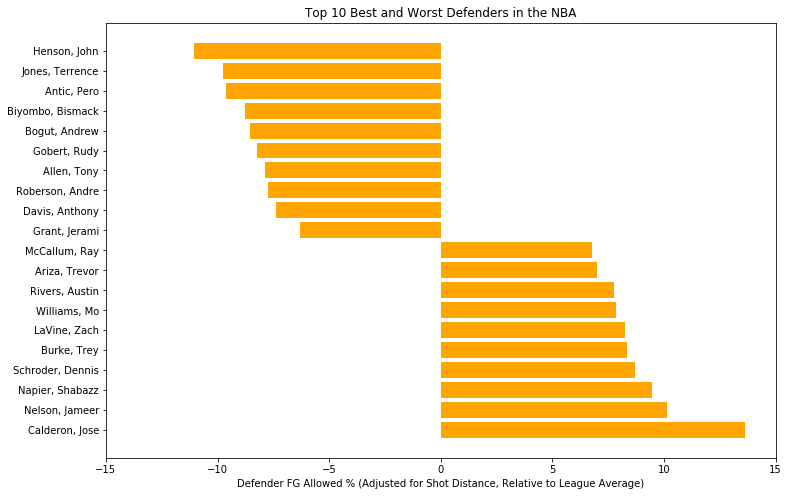

In [30]:
from pylab import *

#Display the top 10
pos = arange(len(result)) 
plt.figure(figsize=(12,8))
barh(pos, result_sorted['Net_FG_Pct_Differential2'], align='center', color = 'orange')
yticks(pos, result_sorted['Defender'])
xlabel('Defender FG Allowed % (Adjusted for Shot Distance, Relative to League Average)')
title('Top 10 Best and Worst Defenders in the NBA')
plt.xlim(-15,15)


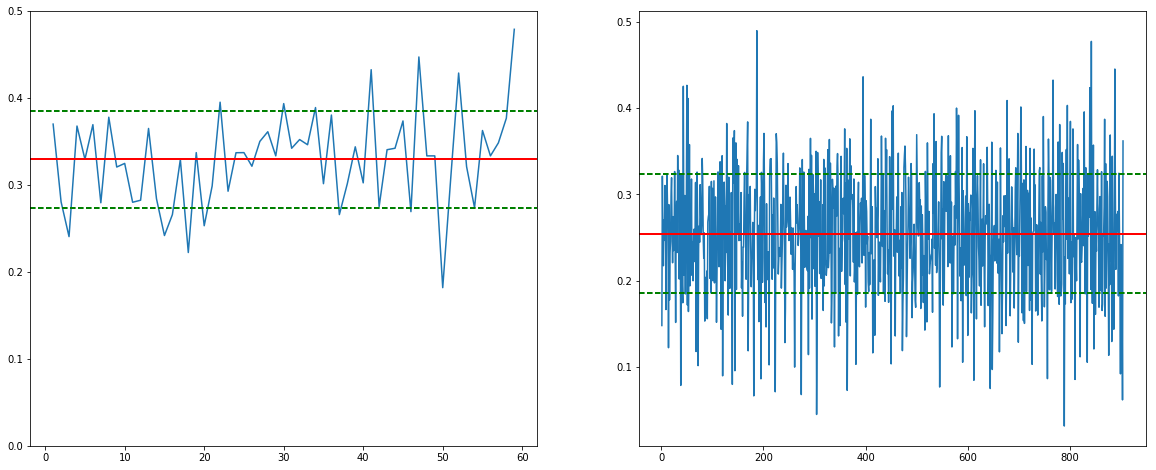

In [14]:
#Is the 3-point shooting rate (as a function of total shots taken) of the Golden State Warriors different than the rate
#for the rest of the league?

plt.figure(figsize=(20,8))

#Find all warriors games. Team name is not available (in a unique form), so we need to create a Warriors player list.
warriors_players = ['leandro barbosa', 'harrison barnes', 'andrew bogut', 'stephen curry', 'festus ezeli', 'draymond green',
                   'justin holiday', 'andre iguodala', 'ognen kuzmic', 'david lee', 'shaun livingston', 'james mcAdoo',
                   'nemanja nedovic', 'brandon rush', 'marreese speights', 'klay thompson']

gsw_only = df[df['player_name'].isin(warriors_players)]

gsw_threes = gsw_only.ix[lambda df: gsw_only['PTS_TYPE'] == 3]

test = gsw_threes.groupby('GAME_ID').count() 
test2 = gsw_only.groupby('GAME_ID').count()

gsw_three_pt_rate = test.ix[ : , 0] / test2.ix[ : , 0]

#print(gsw_three_pt_rate)
#print(gsw_three_pt_rate.ix[: , 0])


game_counter = []
for game in range(len(test)):
    game_counter.append(game + 1)

test['GAME_ID_FIXED'] = game_counter    

#test.head() 

plt.subplot(1,2,1)
plt.plot(test['GAME_ID_FIXED'], (test['player_name'] / test2['player_name']))
plt.axhline(y = gsw_three_pt_rate.mean(), color = 'red', linestyle = 'solid', linewidth = 2)
plt.axhline(y = gsw_three_pt_rate.mean() + gsw_three_pt_rate.std(), color = 'green', linestyle = 'dashed', linewidth = 2)
#plt.axhline(y = league_three_pt_rate.mean() + league_three_pt_rate.std(), color = 'pink', linestyle = 'dashed', linewidth = 2)
plt.axhline(y = gsw_three_pt_rate.mean() - gsw_three_pt_rate.std(), color = 'green', linestyle = 'dashed', linewidth = 2)
plt.ylim(0, 0.5)


non_gsw = df[~df['player_name'].isin(warriors_players)]
league_threes = non_gsw.ix[lambda df: non_gsw['PTS_TYPE'] == 3]

#League game counts threes / shots from both teams, so to get a single team average we need to divide by 2
test_league = league_threes.groupby('GAME_ID').count() / 2
test2_league = df.groupby('GAME_ID').count() / 2

league_three_pt_rate = test_league.ix[ : , 0] / test2_league.ix[ : , 0]



lg_game_counter = []
for game in range(len(test_league)):
    lg_game_counter.append(game + 1)

test_league['GAME_ID_FIXED'] = lg_game_counter    

plt.subplot(1,2,2)
plt.plot(test_league['GAME_ID_FIXED'], (test_league['player_name'] / test2_league['player_name']))
plt.axhline(y = league_three_pt_rate.mean(), color = 'red', linestyle = 'solid', linewidth = 2)
plt.axhline(y = league_three_pt_rate.mean() + league_three_pt_rate.std(), color = 'green', linestyle = 'dashed', linewidth = 2)
plt.axhline(y = league_three_pt_rate.mean() - league_three_pt_rate.std(), color = 'green', linestyle = 'dashed', linewidth = 2)
plt.show()



